# 教師データの解凍

In [37]:
%%bash

7z x -tzip -y data15.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 5833015 bytes (5697 KiB)

Extracting archive: data15.zip
--
Path = data15.zip
Type = zip
Physical Size = 5833015

Everything is Ok

Folders: 7
Files: 1312
Size:       5812290
Compressed: 5833015


# グラフでマルチバイト文字を使うためのライブラリのインストール


In [38]:
!pip install japanize_matplotlib

# モジュールのインポート

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import ReLU, Activation, Dropout, LeakyReLU, Flatten, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import RandomFlip
import matplotlib.pyplot as plt
import japanize_matplotlib
import PIL.Image

# 出力ディレクトリの設定

In [40]:
import os
ODIR = 'results'
os.makedirs(ODIR, exist_ok=True)

# 関数 save_fig：図を保存する

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.2)

# 関数 add_damage：傷を画像に付与する

In [42]:
import cv2
import random
def add_damage(image_path, dst_dir):
    """傷を画像に付与する。
    Args:
        image_path: 画像のパス
        dst_dir: 保存先フォルダ
    Returns:
        dst_base_path: 傷をつけた画像のファイル名
    """

    src_dirname = os.path.basename(os.path.dirname(image_path))
    os.makedirs(dst_dir, exist_ok=True)
    dst_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.png")
    dst_path = os.path.join(dst_dir, dst_base_path)
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)

    center = (center_x, center_y)
    color = (color_r, color_g, color_b)

    cv2.circle(image, center=center, radius=10, color=color, thickness=-1)
    cv2.imwrite(dst_path, image)

    return dst_path

# 関数 generate_images：潜在ベクトルから生成した画像を保存

In [43]:
def generate_images(G, epoch, test_z):
    n = 4

    # 生成画像を保存
    fake_images = G(test_z, training=False)
    output = []
    buff = np.concatenate(fake_images[0:n], axis=1)
    output.append(buff)
    output = (np.concatenate(output, axis=0) * 127.5 + 127.5).astype('uint8')
    output_image = PIL.Image.fromarray(output)
    os.makedirs(os.path.join(ODIR, 'fake'), exist_ok=True)
    output_image.save(os.path.join(ODIR, 'fake', f'fake_image_epoch{epoch:04d}.png'))

# 関数 decode_images：実画像とその復号化結果の比較画像を生成

In [44]:
def decode_images(G, E, real_images, epoch=None, output_path=None):
    n = min(len(real_images), 4)
    x = real_images[:n] # 最初のn枚を取り出す
    real_z = E(x, training=False) # 実画像を符号化
    decoded_images = G(real_z, training=False) # 符号から実画像を復号化
    diff_images = tf.math.abs(x - decoded_images)

    x = np.concatenate(x, axis=1)
    decoded_images = np.concatenate(decoded_images, axis=1)
    diff_images = np.concatenate(diff_images, axis=1)
    output = (np.concatenate([x, decoded_images, diff_images], axis=0) * 127.5 + 127.5).astype('uint8')
    output = np.transpose(output, (1, 0, 2))
    output_image = PIL.Image.fromarray(output)
    if epoch is not None:
        os.makedirs(os.path.join(ODIR, 'real'), exist_ok=True)
        output_image.save(os.path.join(ODIR, 'real', f'real_image_epoch{epoch:04d}.png'))
    elif output_path is not None:
        output_image.save(output_path)

    return output_image

# 画像データセットクラス

In [45]:
class ImageDataset(Sequence):
    def __init__(self, file_list, batch_size):
        self.file_list = file_list # jpgファイルのパスを格納したリスト
        self.batch_size = batch_size # バッチサイズ

    def __len__(self):
        """1エポック分のステップ数を取得する。
        Returns:
            1エポック分のステップ数
        """
        return len(self.file_list) // self.batch_size

    def __getitem__(self, index):
        """バッチサイズ分の画像を取得する。
        Args:
            index (int): ステップ番号
        Returns:
            指定されたステップ番号で使用する画像
        """
        # 指定されたステップ番号で読み込むファイルのパス
        files = self.file_list[self.batch_size * index : self.batch_size * (index + 1)]
        images = [] # 画像を格納するリスト
        for f in files:
            image = PIL.Image.open(f) # 画像の読み込み
            image = image.resize((96, 96)) # 96x96にリサイズ
            image = image.convert('RGB') # 色形式をRGBに変換
            image = np.array(image) # NumPy配列へ変換
            # 画素値の範囲を[0, 255]から[-1, 1]への変換処理
            image = image - 127.5   # [0, 255]から[-127.5, 127.5]への変換
            image = image / 127.5   # [-127.5, 127.5]から[-1, 1]への変換
             # (画像番号、高さ、幅、チャネル)の4次元配列へ変換
            image = image.reshape((1, 96, 96, 3))
            images.append(image) # リストへ画像を追加
        # （バッチサイズ、96, 96, 3）の形状の配列へ変換後に返却
        return np.concatenate(images, axis=0).astype('float32')

# 実習15.1：画像ファイルリスト作成と定数の定義

In [46]:
import glob

file_list=glob.glob('data15/Training/Apple Red 2/**/*.jpg',recursive=True)
print(len(file_list))

batch_size=16
print('バッチサイズ:',batch_size)

num_epochs=150
print('エポック数:',num_epochs)

zdim=128
print('潜在ベクトル次元数:',zdim)

492
バッチサイズ: 16
エポック数: 150
潜在ベクトル次元数: 128


# 実習15.2：符号化器の定義と生成

In [47]:
def make_Eblock(x,filters,kernel_size,strides):
    """同じ構造を持つ層のあつまり（ブロック）への入力を処理する。
    Args:
        x: ブロックへの入力
        filters: 転置畳み込み層のフィルタ数
        kernel_size: 転置畳み込みのカーネルサイズ
        strides: 転置畳み込みのストライド
    Returns:
        ブロックからの出力
    """
    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)
    return x
def make_E(zdim):
    """符号化器を定義する。
    Args:
        zdim: 潜在ベクトルの次元数
    Returns:
        符号化器
    """
    # 1枚の画像（高さ96、幅96、チャネル数3）の形状を定義し、
    # 符号化器に教える。
    inputs=Input(shape=(96,96,3))
    x=make_Eblock(inputs,32,4,2)
    x=make_Eblock(x,64,4,2)
    x=make_Eblock(x,128,4,2)
    x=make_Eblock(x,256,4,2)
    x=make_Eblock(x,512,4,1)
    x=make_Eblock(x,512,1,1)
    # 出力層。潜在ベクトルと同じ次元数を持つ符号を出力する。
    outputs=Conv2D(filters=zdim,kernel_size=1,strides=1,use_bias=False)(x)
    # 入出力を指定して、符合化器を生成。
    model=Model(inputs=inputs,outputs=outputs)
    return model

# 関数の外。生成器の生成
E=make_E(zdim)
E.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 47, 47, 32)        1536      
                                                                 
 batch_normalization_62 (Bat  (None, 47, 47, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 47, 47, 32)        0         
                                                                 
 conv2d_72 (Conv2D)          (None, 22, 22, 64)        32768     
                                                                 
 batch_normalization_63 (Bat  (None, 22, 22, 64)       256       
 chNormalization)                                         

# 実習15.3：生成器の定義と生成

In [48]:
def make_Gblock(x,filters,kernel_size,strides):
    """同じ構造を持つ層のあつまり（ブロック）への入力を処理する。
    Args:
        x: ブロックへの入力
        filters: 転置畳み込み層のフィルタ数
        kernel_size: 転置畳み込みのカーネルサイズ
        strides: 転置畳み込みのストライド
    Returns:
        ブロックからの出力
    """
    # 転置畳み込み。バイアスは使用（学習）しない
    x=Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)
    return x
def make_G(zdim):
    """生成器を定義する。
    Args:
        zdim: 潜在ベクトルの次元数
    Returns:
        符号化器
    """
    # 1個の潜在ベクトルを高さ1、幅1、チャネル数zdimの画像として生成器に入力する。
    # 生成器への入力サイズを入力層に教える。
    inputs=Input(shape=(1,1,zdim))
    x=make_Gblock(inputs,256,4,1)
    x=make_Gblock(x,128,4,2)
    x=make_Gblock(x,64,4,2)
    x=make_Gblock(x,32,5,2)
    x=Conv2DTranspose(filters=3,kernel_size=4,strides=2,use_bias=False)(x)
    outputs=Activation('tanh')(x) # 出力層の活性化関数
    # 入出力を指定して、生成器を生成。
    model=Model(inputs=inputs,outputs=outputs)
    return model

# 関数の外。生成器の生成
G=make_G(zdim)
G.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1, 1, 128)]       0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 4, 4, 256)        524288    
 Transpose)                                                      
                                                                 
 batch_normalization_68 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 10, 10, 128)      524288    
 Transpose)                                                      
                                                          

# 実習15.4：識別器の定義と生成

In [49]:
def make_Dblock(x,filters,kernel_size,strides,use_bn=True):
    """同じ構造を持つ層のあつまり（ブロック）への入力を処理する。
    Args:
        x: ブロックへの入力
        filters: 転置畳み込み層のフィルタ数
        kernel_size: 転置畳み込みのカーネルサイズ
        strides: 転置畳み込みのストライド
        use_bn: バッチ正規化を使うか否か
    Returns:
        ブロックからの出力
    """
    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides)(x)
    if use_bn:
        x=BatchNormalization()(x)
    x=LeakyReLU(0.1)(x)
    x=Dropout(rate=0.2)(x)
    return x
def make_D(zdim):
    """識別器を定義する。
    Args:
        zdim: 潜在ベクトルの次元数
    Returns:
        識別器
    """
    # 実画像または生成画像の真贋判定を行う部分。
    # 1個の画像のサイズは高さ96、幅96、チャネル数3。
    # 識別器への入力サイズ（1枚の画像サイズ）を入力層に教える。
    x_inputs=Input(shape=(96,96,3))
    x=RandomFlip(mode='horizontal')(x_inputs) # データ拡張。左右反転
    x=make_Dblock(x,32,4,2,False)
    x=make_Dblock(x,64,4,2)
    x=make_Dblock(x,128,4,2)
    x=make_Dblock(x,256,4,2)
    x=Conv2D(filters=256,kernel_size=3,strides=3)(x)

    # 符号または潜在ベクトルの真贋判定を行う部分。
    # 1個の潜在ベクトルを高さ1、幅1、チャネル数zdimの画像として識別器にする。
    # 識別器への入力サイズを入力層に教える。
    z_inputs=Input(shape=(1,1,zdim))
    z=make_Dblock(z_inputs,256,1,1,False)

    # 画像から抽出した特徴と、ベクトルから抽出した特徴を結合
    xz=Concatenate(axis=3)([x,z])
    # 結合した特徴から、真贋判定のための特徴を抽出
    xz=make_Dblock(xz,512,1,1,False)
    # 特徴量を画像形式から1次元配列へ変換。異常スコアの計算に使用する。
    feature=Flatten()(xz)
    # 真贋判定のための特徴をさらに抽出
    xz=Conv2D(filters=1,kernel_size=1, strides=1)(xz)
    outputs=Activation('sigmoid')(xz) # 特徴をシグモイド関数で2クラス分類する。
    # 入出力を指定して、識別器を生成。
    model=Model(inputs=(x_inputs,z_inputs),outputs=(outputs,feature))
    return model

# 関数の外。識別器の生成
D=make_D(zdim)
D.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 random_flip_2 (RandomFlip)     (None, 96, 96, 3)    0           ['input_17[0][0]']               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 47, 47, 32)   1568        ['random_flip_2[0][0]']          
                                                                                                  
 leaky_re_lu_78 (LeakyReLU)     (None, 47, 47, 32)   0           ['conv2d_78[0][0]']              
                                                                                           

# 実習15.5：識別器の損失関数

In [50]:
from tensorflow.keras.losses import BinaryCrossentropy

bce=BinaryCrossentropy() # 2クラス分類用交差エントロピー誤差

def D_loss_func(real_pred,fake_pred):
    """識別器用の損失関数
    Args:
        real_pred: 実画像に対して実画像である予測確率
        fake_pred: 生成画像に対して実画像である予測確率
    Returns:
        実画像と生成画像について実画像と予測した損失
    """
    real_loss=bce(tf.ones_like(real_pred) ,real_pred)
    fake_loss=bce(tf.zeros_like(fake_pred),fake_pred)
    total_loss=real_loss+fake_loss
    return total_loss
# 関数の外。
print('実画像を本物、生成画像を偽物と正しく判定できた場合')
real_pred=tf.ones((batch_size,1),dtype='float32')
fake_pred=tf.zeros((batch_size,1),dtype='float32')
value=D_loss_func(real_pred,fake_pred)
print('損失:',value)

print('実画像を偽物、生成画像を本物と誤って判定した場合')
value=D_loss_func(fake_pred,real_pred)
print('損失:',value)

実画像を本物、生成画像を偽物と正しく判定できた場合
損失: tf.Tensor(-0.0, shape=(), dtype=float32)
実画像を偽物、生成画像を本物と誤って判定した場合
損失: tf.Tensor(30.758186, shape=(), dtype=float32)


# 実習15.6：符号化器と生成器の損失関数

In [51]:
from tensorflow.keras.losses import MeanAbsoluteError

mae=MeanAbsoluteError() # 平均絶対誤差。再構成損失用
alpha=0.01 # 識別損失と再構成損失のバランスをとるハイパーパラメータ
def GE_loss_func(real_pred,fake_pred,z,ge_z,real_images,decoded_image):
    """識別器用の損失関数
    Args:
        real_pred: (実画像, 符号)に対して本物である予測確率
        fake_pred: (生成画像, 潜在ベクトル)に対して本物である予測確率
        z: 生成器に入力した潜在ベクトル
        ge_z: 潜在ベクトルから画像を生成し、それを符号化した値
        real_images: 実画像
        decoded_images: 符号化器で実画像の符号を計算。その符号から生成した画像
    Returns:
        識別損失と再構成損失の和
    """
    # (生成画像, 潜在ベクトル)を本物と予測した確率が1に近いか（識別機をだませたか）
    loss1=bce(tf.ones_like(real_pred) ,fake_pred)
    # (実画像, 符号)を本物と予測した確率が0に近いか（識別機をだませたか）
    loss2=bce(tf.zeros_like(fake_pred),real_pred)
    loss_ge1=loss1+loss2

    # 実画像と、その符号から生成した画像が近いか（実画像を正確に符号化・生成できたか）
    loss3=tf.math.reduce_sum(tf.math.abs(real_images-decoded_image))
    # 潜在ベクトルと、その生成画像を符号化したものが近いか（画像生成と符号化を正確にできたか）
    loss4=tf.math.reduce_sum(tf.math.abs(z-ge_z))
    loss_ge2=loss3+loss4
    return (1-alpha)*loss_ge1+alpha*loss_ge2
# 関数の外
real_pred=tf.ones((batch_size,1),dtype='float32')
fake_pred=tf.zeros((batch_size,1),dtype='float32')
# 潜在ベクトルの代わり：形状(batch_size,1,1,zdim)
z=tf.ones((batch_size,1,1,zdim),dtype='float32')
# 疑似符号データの代わり：形状(batch_size,1,1,zdim)
ge_z=tf.zeros((batch_size,1,1,zdim),dtype='float32')
# 実画像の代わり
real_images=tf.ones((batch_size,96,96,3),dtype='float32')
# 実画像を符号化、その符号から生成した画像の代わり
decoded_images=tf.zeros((batch_size,96,96,3),dtype='float32')
value=GE_loss_func(real_pred,fake_pred,z,ge_z,real_images,decoded_images)
print('損失:',value)

損失: tf.Tensor(4474.6104, shape=(), dtype=float32)


# 実習15.7：最適化手法の設定とステップ単位の学習を行う関数

In [52]:
GE_optimizer=tf.keras.optimizers.Adam(4e-4) # 生成器と符号化器の最適化手法。学習率4e-4
D_optimizer=tf.keras.optimizers.Adam(8e-4) # 識別器の最適化手法。学習率8e-4

@tf.function
def train_step(real_images,z,noise1,noise2):
    """ステップ単位の学習を行う。
    Args:
        real_images: 実画像
        z: 潜在ベクトル
        noise1: 実画像に加えるノイズ。データ拡張用
        noise2: 生成画像に加えるノイズ。データ拡張用
    Returns:
        生成器と符号化器の損失
        識別器の損失
    """
    # 各層での計算をG_tapeとD_tapeに記録する（計算グラフの作成）
    with tf.GradientTape() as GE_tape, tf.GradientTape() as D_tape:
        real_z=E(real_images,training=True)  # 実画像の符号化結果を取得
        # 潜在ベクトルから生成器で画像を生成
        fake_images=G(z,training=True)
        fake_z=E(fake_images,training=True)  # 生成画像の符号化結果を取得
        # 実画像とその符号化結果に対する真贋判定
        real_pred,real_feat=D((real_images+noise1,real_z), training=True)
        # 生成画像とその符号化結果に対する真贋判定
        fake_pred,fake_feat=D((fake_images+noise2,fake_z), training=True)
        # 識別器の損失を計算
        D_step_loss=D_loss_func(real_pred,fake_pred)
        # 実画像の符号から、画像を生成
        decoded_images=G(real_z,training=True)
        # 生成器と符号化器の損失を計算
        GE_step_loss=GE_loss_func(real_pred,fake_pred,z,fake_z,real_images,decoded_images)

    # 識別器のパラメータについて、損失の勾配を計算
    D_gradient=D_tape.gradient(D_step_loss, D.trainable_variables)
    # 生成器と符号化器のパラメータについて、損失の勾配を計算
    GE_gradient=GE_tape.gradient(GE_step_loss, G.trainable_variables+E.trainable_variables)
    # 損失の勾配を使って、識別器のパラメータを更新
    D_optimizer.apply_gradients(zip(D_gradient,D.trainable_variables))
    # 損失の勾配を使って、生成器と符号化器のパラメータを更新
    GE_optimizer.apply_gradients(zip(GE_gradient,G.trainable_variables+E.trainable_variables))
    return GE_step_loss, D_step_loss

# 関数の外
test_images=tf.ones((batch_size,96,96,3),dtype='float32')
z=tf.random.normal((batch_size,1,1,zdim),stddev=0.1)
noise1=tf.random.normal(shape=test_images.shape,stddev=0.01,dtype=tf.float32)
noise2=tf.random.normal(shape=test_images.shape,stddev=0.01,dtype=tf.float32)
GE_step_loss , D_step_loss=train_step(test_images,z,noise1,noise2)
print('GE_step_loss:',GE_step_loss)
print('D_step_loss:',D_step_loss)

GE_step_loss: tf.Tensor(4440.2554, shape=(), dtype=float32)
D_step_loss: tf.Tensor(1.4115727, shape=(), dtype=float32)


# 実習15.8：学習

In [53]:
num_samples=4 # 学習過程で生成する画像の枚数
# 学習過程で生成する画像の潜在ベクトル
seed=tf.random.normal((num_samples,1,1,zdim),stddev=0.1)
print(seed.shape)

dataset=ImageDataset(file_list,batch_size) # 教師画像データセット
print('ステップ数:', len(dataset))
images=dataset[0] # ステップ番号の画像を取り出す
print('教師データの形状:', images.shape)

GE_loss_history=[] # 各エポックの生成器と符号化器の損失を格納するリスト
D_loss_history=[] # 各エポックの識別器の損失を格納するリスト

for epoch in range(num_epochs):
    GE_epoch_loss=0 # エポックでの生成器と符号化器の損失
    D_epoch_loss=0 # エポックでの識別器の損失
    # データ拡張用に生成するノイズの標準偏差。学習が進むにつれて小さくする。
    scale=0.1*(num_epochs-epoch)/num_epochs
    for real_images in dataset: # データセットから1バッチ分の画像を取り出す
        # 潜在ベクトル：形状(batch_size,1,1,zdim)、平均0、標準偏差0.1の正規分布に従う乱数を生成
        z=tf.random.normal((batch_size,1,1,zdim),stddev=0.1)
        # データ拡張用ノイズ。noise1：実画像に加えるノイズ、noise2：生成画像に加えるノイズ
        noise1=tf.random.normal(shape=test_images.shape,stddev=0.01,dtype=tf.float32)
        noise2=tf.random.normal(shape=test_images.shape,stddev=0.01,dtype=tf.float32)
        GE_step_loss,D_step_loss=train_step(real_images,z,noise1,noise2)
        GE_epoch_loss+=GE_step_loss
        D_epoch_loss+=D_step_loss

    # 定義済の関数を利用して、潜在ベクトルから画像を生成し、保存する。
    generate_images(G,epoch+1,seed)
    # 実画像を符号化、その符号から生成した画像を保存する。
    GE_loss_history.append(GE_epoch_loss) # 現エポックの生成器の損失をリストに追加
    D_loss_history.append(D_epoch_loss) # 現エポックの識別器の損失をリストに追加
    print(f'Epoch {epoch+1},GE_loss: {GE_epoch_loss:.4f}, D_loss: {D_epoch_loss:.4F}')

(4, 1, 1, 128)
ステップ数: 30
教師データの形状: (16, 96, 96, 3)
Epoch 1,GE_loss: 56347.6562, D_loss: 5.2704
Epoch 2,GE_loss: 23711.1523, D_loss: 4.4140
Epoch 3,GE_loss: 16023.0020, D_loss: 4.0762
Epoch 4,GE_loss: 13381.0449, D_loss: 3.7958
Epoch 5,GE_loss: 12463.5674, D_loss: 0.7282
Epoch 6,GE_loss: 11426.2070, D_loss: 1.6890
Epoch 7,GE_loss: 10633.5439, D_loss: 1.2963
Epoch 8,GE_loss: 10006.9990, D_loss: 0.8212
Epoch 9,GE_loss: 9685.0176, D_loss: 0.6807
Epoch 10,GE_loss: 9977.8486, D_loss: 3.0033
Epoch 11,GE_loss: 9874.0830, D_loss: 2.6325
Epoch 12,GE_loss: 8969.8457, D_loss: 2.3638
Epoch 13,GE_loss: 8542.9707, D_loss: 1.1986
Epoch 14,GE_loss: 8438.1846, D_loss: 0.2319
Epoch 15,GE_loss: 8350.9209, D_loss: 4.9463
Epoch 16,GE_loss: 8151.5923, D_loss: 4.9408
Epoch 17,GE_loss: 7986.5186, D_loss: 1.9991
Epoch 18,GE_loss: 7771.8745, D_loss: 4.6808
Epoch 19,GE_loss: 7623.9185, D_loss: 2.0956
Epoch 20,GE_loss: 7448.5225, D_loss: 7.4785
Epoch 21,GE_loss: 7595.0659, D_loss: 6.6684
Epoch 22,GE_loss: 7456.818

# 関数 anomaly_score：異常度を計算する

In [54]:
def anomaly_score(real_image, beta=0.1):
    """異常度を計算する。
    Args:
        real_images: 実画像
        beta: 再構成損失と識別損失のバランスを取るハイパーパラメータ
    Returns:
        異常度
    """
    real_z = E(real_image, training=False) # 実画像の符号を計算
    decoded_image = G(real_z, training=False) # 符号から実画像を再構成
    # 実画像とその符号についての真贋判定と特徴量を取得
    real_pred, real_feat = D((real_image, real_z), training=False)
    # 再構成画像と実画像の符号についての真贋判定と特徴量を取得
    deco_pred, deco_feat = D((decoded_image, real_z), training=False)
    # 実画像に対する再構成画像の誤差を計算
    residual_loss = tf.math.reduce_sum(tf.math.abs(real_image - decoded_image))
    # 実画像の特徴量に対する、再構成画像の特徴量の誤差を計算
    discri_loss = tf.math.reduce_sum(tf.math.abs(real_feat - deco_feat))
    # 異常度を計算
    score = (1 - beta) * residual_loss + beta * discri_loss
    return score.numpy()

# 実習15.9：傷なしリンゴ画像の異常度計算

異常度: 3108.321


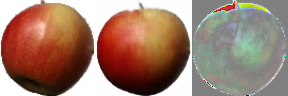

異常度: 2236.068


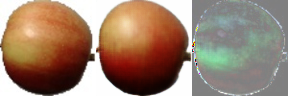

異常度: 2438.588


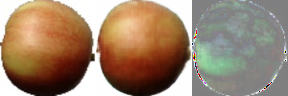

異常度: 1505.8651


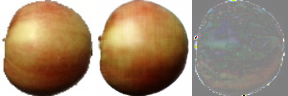

異常度: 2351.341


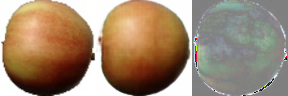

In [55]:
from IPython.display import display

# 傷なしリンゴ画像ファイルの一覧を取得
test_files=glob.glob('data15/Test/Apple Red 2/**/*.jpg',recursive=True)
# データセット生成
test_dataset=ImageDataset(test_files,batch_size=1)

for i in range(5): # 5枚の画像について異常度を計算
    test_image=test_dataset[i]
    score=anomaly_score(test_image)
    print('異常度:',score)
    # テスト画像を符号化し、その符号から画像を生成する。
    result=decode_images(G,E,test_image,output_path=f'test_Apple{i}.png')
    display(result) # テスト画像を符号化し、生成画像、差の絶対値画像を並べて表示

# 実習15.10：学習した傷なしリンゴとは別の果物の画像（ほおずき）の異常度計算

異常度: 8260.297


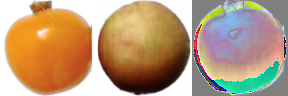

異常度: 9133.314


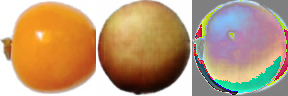

異常度: 7994.3267


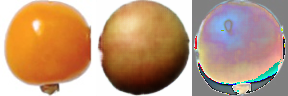

異常度: 9073.626


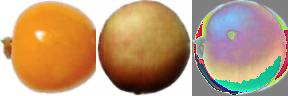

異常度: 8992.92


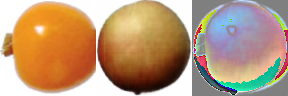

In [56]:
from IPython.display import display

# 別の果物の画像ファイルの一覧を取得
test_files=glob.glob('data15/Test/Physalis/**/*.jpg',recursive=True)
# データセット生成
test_dataset=ImageDataset(test_files,batch_size=1)

for i in range(5): # 5枚の画像について異常度を計算
    test_image=test_dataset[i]
    score=anomaly_score(test_image)
    print('異常度:',score)
    # テスト画像を符号化し、その符号から画像を生成する。
    result=decode_images(G,E,test_image,output_path=f'Physalis{i}.png')
    display(result) # テスト画像を符号化し、生成画像、差の絶対値画像を並べて表示

# 実習15.11：学習したリンゴに傷をつけた画像の異常度計算

異常度: 2087.0947


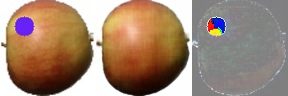

異常度: 2050.1226


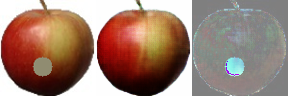

異常度: 1894.5707


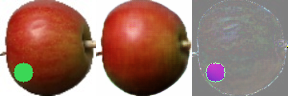

異常度: 2092.4207


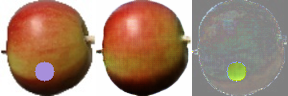

異常度: 1968.5491


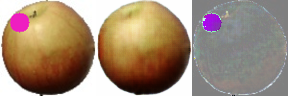

In [59]:
from IPython.display import display

# 傷なしリンゴ画像ファイルの一覧を取得
test_files=glob.glob('data15/Training/Apple Red 2/**/*.jpg',recursive=True)
damaged_files=[] # 傷をつけた画像ファイルを格納するリスト

# 傷なしリンゴ画像に傷をつける
for i in range(len(test_files)):
    # 傷をつけた画像ファイルを取得
    damaged_file=add_damage(test_files[i],os.path.join(ODIR, 'damaged'))
    damaged_files.append(damaged_file)

# 傷のあるリンゴ画像ファイルのデータセットを生成
test_dataset=ImageDataset(damaged_files,batch_size=1)

for i in range(5): # 5枚の画像について異常度を計算
    test_image=test_dataset[i]
    score=anomaly_score(test_image)
    print('異常度:',score)
    # テスト画像を符号化し、その符号から画像を生成する。
    result=decode_images(G,E,test_image,output_path=f'test_damaged_Apple{i}.png')
    display(result) # テスト画像を符号化し、生成画像、差の絶対値画像を並べて表示

# おまけ：損失の推移を可視化

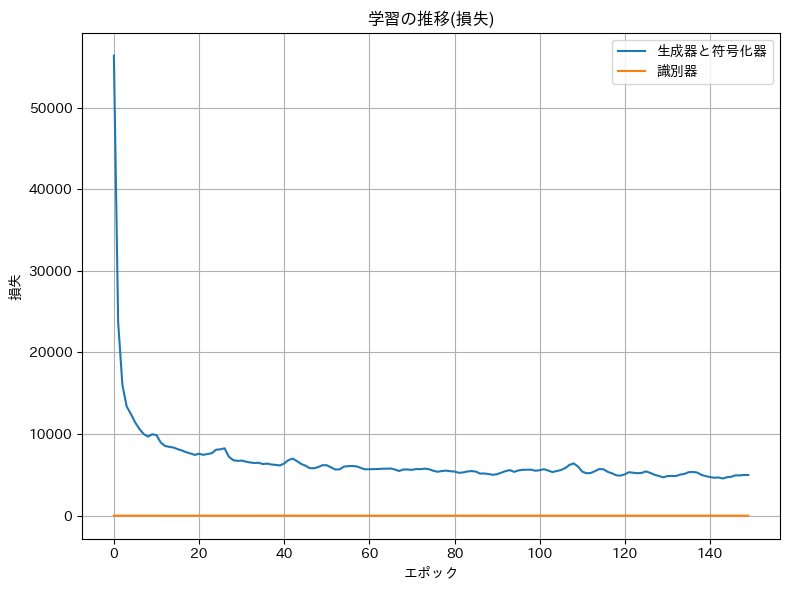

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(GE_loss_history, label='生成器と符号化器')
plt.plot(D_loss_history, label='識別器')
plt.legend()
plt.grid()
plt.title('学習の推移(損失)')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.tight_layout()
save_fig(plt, 'loss')
plt.show()